In [10]:
# Warings ov
import warnings
warnings.filterwarnings('ignore')

# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# YF
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

# ML
import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Convolution1D, Convolution2D, Flatten, Dense, \
    Input, Lambda, Activation, BatchNormalization, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error


class ConditionedTimeseriesGenerator(TimeseriesGenerator):
    def __init__(self, input_timeseries, condition_timeseries):
        self.input_timeseres = input_timeseries
        self.condition_timeseries = condition_timeseries
        
    def __len__(self):
        return len(self.input_timeseres)

    def __getitem__(self, index):
        samples, targets = self.input_timeseres[index]
        samples_cond, _ = self.condition_timeseries[index]
        return (samples, samples_cond), targets

    def get_config(self):
        d = {}
        d.update(self.input_timeseres.get_config())
        d.update(self.condition_timeseries.get_config())
        return d

# DATA

## 1. Data from API

In [11]:
###########################################################
###################        DATA        ####################
###########################################################


# Tickers
tickers = ['^GSPC', '^VIX', '^TNX', 'EURUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'GBPUSD=X']

# dates rolling
start_date = ['2009-1-1','2010-1-1','2011-1-1','2012-1-1','2013-1-1','2014-1-1','2015-1-1','2016-1-1']
train_end = ['2011-12-31','2012-12-31','2013-12-31','2014-12-31','2015-12-31','2016-12-31','2017-12-31','2018-12-31']
test_start = ['2012-1-1','2013-1-1','2014-1-1','2015-1-1','2016-1-1','2017-1-1','2018-1-1','2019-1-1']
end_date = ['2012-12-31','2013-12-31','2014-12-31','2015-12-31','2016-12-31','2017-12-31','2018-12-31','2019-12-31']

datasets_train = []
datasets_test = []
mu_train_lst = np.zeros((len(tickers), len(start_date)))
sigma_train_lst = np.zeros((len(tickers), len(start_date)))
i = 0

for st, te, ts, ed in zip(start_date,train_end,test_start,end_date):
    
    # data Close
    data_close = pdr.get_data_yahoo(tickers, start=st, end=ed)['Adj Close']
    
    # data returns
    data = data_close.shift(1) / data_close - 1

    # Sets
    data_train = data[st:te].dropna()
    data_test = data[ts:ed].dropna()

    # mu sigma train
    mu_train = data_train.mean()
    sigma_train = data_train.std()

    # Final sets
    data_train_prod = (data_train - mu_train) / sigma_train
    data_test_prod = (data_test - mu_train) / sigma_train

    datasets_train.append(data_train_prod)
    datasets_test.append(data_test_prod)
    sigma_train_lst[i] = sigma_train
    mu_train_lst[i] = mu_train
    i += 1
    

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed


## 2. Data visualization

,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2014-01-03,-0.063760,1.804818,1.177443,1.449669,1.227576,0.064066,-0.171860,0.383233
2014-01-06,0.472946,0.627197,0.820474,0.136528,0.275136,0.320432,0.507499,0.145251
2014-01-07,-0.313761,0.576924,-0.491606,0.699499,-0.111582,-0.684266,0.355735,0.569507
2014-01-08,0.008163,-0.603108,0.142202,-0.492585,0.109057,0.049890,-0.876427,-0.002867
2014-01-09,1.013836,0.265736,0.497881,-0.535724,-0.520866,-0.015866,0.445266,-0.072208
...,...,...,...,...,...,...,...,...
2016-12-22,-0.729190,-0.179091,-0.662464,0.345747,0.074173,0.243975,-0.144495,-0.230957
2016-12-23,-1.075957,-0.112739,-0.194693,0.693703,0.844948,-0.121692,0.161426,-0.063566
2016-12-28,-0.063741,-0.510862,-0.135514,-0.332526,-0.064314,1.013711,1.023742,-0.997919


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2017-01-04,0.140958,0.329533,0.595277,0.144915,0.411218,-0.642581,-0.056202,1.023903
2017-01-05,-0.188487,-0.513077,-1.341579,-0.284995,-1.118345,0.115478,1.607123,0.144308
2017-01-06,-0.331934,0.856656,-1.708783,0.900267,-1.334401,-0.386208,-0.966629,0.341932
2017-01-09,-1.015762,-1.400440,1.128498,-0.383718,2.082674,0.442822,0.791418,-0.317216
2017-01-10,-2.043039,0.637927,-0.947843,1.972798,1.085202,0.024987,-0.076620,0.025286
...,...,...,...,...,...,...,...,...
2017-12-21,-0.720260,-0.887786,-0.569469,-0.187513,0.113459,-0.207526,0.276780,0.080164
2017-12-22,0.407519,0.120086,0.244883,-0.202049,-0.164861,0.078768,-0.092598,-0.413149
2017-12-27,0.177045,0.276200,0.157231,0.079010,-0.047187,-0.067740,0.987526,-0.320419


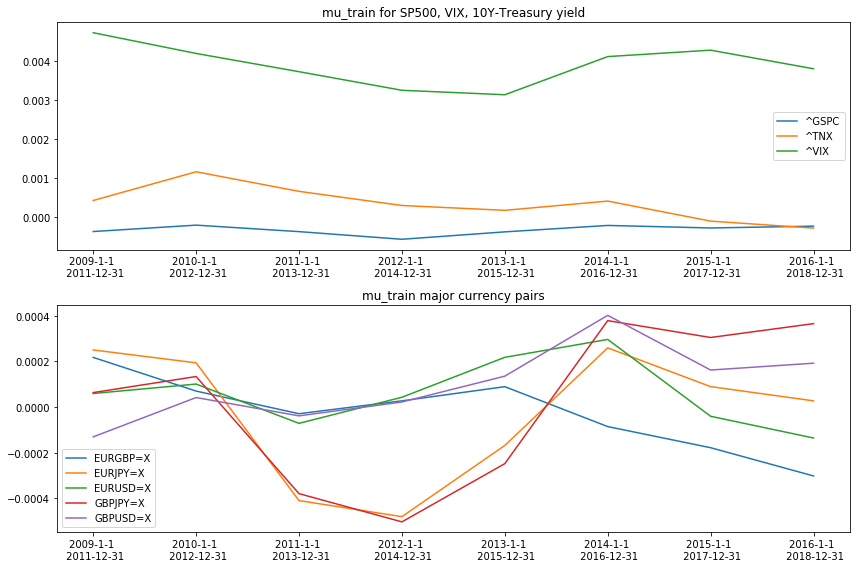

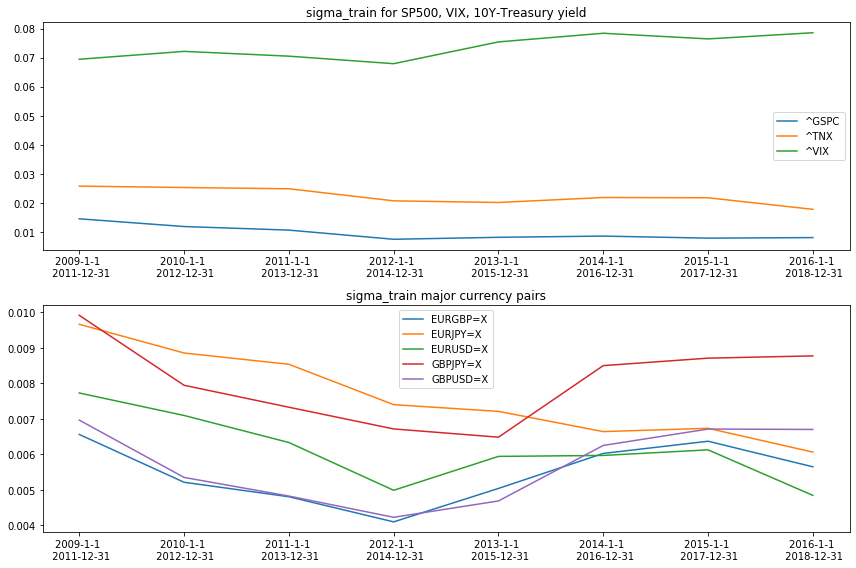

In [12]:
######################
# Data visualization #
######################

# Sets ex

display(datasets_train[5])
display(datasets_test[5])


# Plots of mu / sigma train

# Training dates
x_train_dates = []
x_train_dates_simple = []
for star, endd in zip(start_date, train_end):
    per = star + ' \n ' + endd
    per2 = star + ' / ' + endd
    x_train_dates.append(per)
    x_train_dates_simple.append(per2)
    
x_train_dates = np.array(x_train_dates)
x_train_dates_simple = np.array(x_train_dates_simple)


# Testing dates
x_test_dates_simple = []
for star, endd in zip(test_start, end_date):
    per = star + ' / ' + endd
    x_test_dates_simple.append(per)
x_test_dates_simple = np.array(x_test_dates_simple)


# Mu train
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
st = axes[0].plot(mu_train_lst[:,-3:])
cur = axes[1].plot(mu_train_lst[:,:-3])
axes[0].legend(st, datasets_train[0].columns.values[-3:], loc='best')
axes[1].legend(cur, datasets_train[0].columns.values[:-3], loc='best')
axes[0].set_title('mu_train for SP500, VIX, 10Y-Treasury yield')
axes[1].set_title('mu_train major currency pairs')
for ax in axes:
    ax.set_xticks(range(len(x_train_dates)))
    ax.set_xticklabels(x_train_dates)
fig.tight_layout()
fig.show()


# Sigma train
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
st = axes[0].plot(sigma_train_lst[:,-3:])
cur = axes[1].plot(sigma_train_lst[:,:-3])
axes[0].legend(st, datasets_train[0].columns.values[-3:], loc='best')
axes[1].legend(cur, datasets_train[0].columns.values[:-3], loc='best')
axes[0].set_title('sigma_train for SP500, VIX, 10Y-Treasury yield')
axes[1].set_title('sigma_train major currency pairs')
for ax in axes:
    ax.set_xticks(range(len(x_train_dates)))
    ax.set_xticklabels(x_train_dates)
fig.tight_layout()
fig.show()

# WAVENET

## 1. Blocks

In [19]:
# WaveNet Block
def WaveNetBlock(filters, kernel_size, dilation_rate, activation=None, connection_parametrized=False):
    def f(input_):
        residual = input_
        
        relu_out = Convolution1D(filters, kernel_size,
                                          dilation_rate=dilation_rate,
                                          padding='causal',
                                          activation='relu')(input_)
        
        skip_out = Convolution1D(1, 1, activation=activation, padding='causal')(relu_out)
        
        if connection_parametrized:
            residual = Dense(1, activation='linear', use_bias=False)(residual)
            
        out = keras.layers.Add()([relu_out, residual])
        
        return out, skip_out
    return f



# Conditional Block
def ConditionedBlock(filters, kernel_size, dilation_rate, activation=None):
    def f(input_, condition_input):
        input_wave, _ = WaveNetBlock(filters, kernel_size, dilation_rate, activation=activation, connection_parametrized=True)(input_)
        condition_wave, _ = WaveNetBlock(filters, kernel_size, dilation_rate, activation=activation, connection_parametrized=True)(condition_input)   
        merged = keras.layers.Add()([input_wave, condition_wave])
        out = Convolution1D(1, 1, activation=activation, padding='causal')(merged)
        return out
    return f


make_tensorboard_callback = lambda key: keras.callbacks.TensorBoard(log_dir=f"logs/fit/{key}/" + pd.to_datetime('now').strftime("%Y%m%d-%H%M%S"), histogram_freq=1)



## 2. Evaluation Functions

In [14]:
def evaluate_model(model, hist, training_per, testing_per):
    ''' Evaluate Model Function'''
    
    print('Training Period:', training_per)
    print('Testing Period:', testing_per)
    total_mae = mean_absolute_error(train_gen_df[win_length:], np.zeros_like(train_gen_df[win_length:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(train_data_gen)), train_gen_df[win_length:]) 
    print(f'train MAE: {model_mae: 0.4f} ({model_mae/total_mae: 0.2%}), total={total_mae: 0.4f}')
    total_mae = mean_absolute_error(test_gen_df[win_length:], np.zeros_like(test_gen_df[win_length:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(test_data_gen)), test_gen_df[win_length:]) 
    print(f'test MAE: {model_mae: 0.4f} ({model_mae/total_mae: 0.2%}), total={total_mae: 0.4f}')
    plt.scatter(np.squeeze(model.predict(train_data_gen)), train_gen_df[win_length:])
    plt.title('training')
    plt.xlabel('prediction')
    plt.subplots()
    plt.scatter(np.squeeze(model.predict(test_data_gen)), test_gen_df[win_length:])
    plt.title('testing')
    plt.xlabel('prediction')
    pd.DataFrame(hist.history).plot()
    plt.show(block=True)
    
    
def evaluate_model_year(model, hist, test_start):
    ''' Evaluate Model w MASE'''
    
    naive = []
    naive_val = []
    mase = []
    mase_val_lst = []
    
    
    total_mae_train = mean_absolute_error(train_gen_df[win_length:], train_gen_df[win_length-1:-1])
    model_mae_train = mean_absolute_error(np.squeeze(model.predict(train_data_gen)), train_gen_df[win_length:]) 
    mase_train = model_mae_train / total_mae_train
    
    total_mae_val = mean_absolute_error(test_gen_df[win_length:], test_gen_df[win_length-1:-1])
    model_mae_val = mean_absolute_error(np.squeeze(model.predict(test_data_gen)), test_gen_df[win_length:]) 
    mase_val = model_mae_val / total_mae_val
    
    period = test_start[:4]
    
    naive.append(total_mae_train)
    naive_val.append(total_mae_val)
    mase.append(mase_train)
    mase_val_lst.append(mase_val)
    
    return naive, naive_val, mase, mase_val_lst


def evaluate_model_year_hits(model, hist, test_start):
    ''' Evaluate Model w HITS'''
    
    naive = []
    naive_val = []
    hits = []
    hits_val_lst = []
    
    
    total_hits_train = np.sum(np.abs(np.sign(train_gen_df[win_length:].values) + 
                              np.sign(train_gen_df[win_length-1:-1].values)) / train_gen_df[win_length:].shape[0] / 2)
    model_hits_train = np.sum(np.abs(np.sign(np.squeeze(model.predict(train_data_gen))) + 
                              np.sign(train_gen_df[win_length-1:-1].values)) / train_gen_df[win_length:].shape[0] / 2)
    hits_train = model_hits_train / total_hits_train
    
    
    
    
    total_hits_test = np.sum(np.abs(np.sign(test_gen_df[win_length:].values) + 
                              np.sign(test_gen_df[win_length-1:-1].values)) / test_gen_df[win_length:].shape[0] / 2)
    
    model_hits_test = np.sum(np.abs(np.sign(np.squeeze(model.predict(test_data_gen))) + 
                              np.sign(test_gen_df[win_length-1:-1].values)) / test_gen_df[win_length:].shape[0] / 2)
    hits_test = model_hits_test / total_hits_test
    
    
    period = test_start[:4]
    
    naive.append(total_hits_train)
    naive_val.append(total_hits_test)
    hits.append(model_hits_train)
    hits_val_lst.append(model_hits_test)
    
    return naive, naive_val, hits, hits_val_lst


def evaluate_model_year_cond(model, hist, test_start):
    ''' Evaluate Model w MASE conditional'''
    naive = []
    naive_val = []
    mase = []
    mase_val_lst = []
    
    
    total_mae_train = mean_absolute_error(train_gen_df[win_length:], train_gen_df[win_length-1:-1])
    model_mae_train = mean_absolute_error(np.squeeze(model.predict(cond_gen)), train_gen_df[win_length:]) 
    mase_train = model_mae_train / total_mae_train
    
    total_mae_val = mean_absolute_error(test_gen_df[win_length:], test_gen_df[win_length-1:-1])
    model_mae_val = mean_absolute_error(np.squeeze(model.predict(test_cond_gen)), test_gen_df[win_length:]) 
    mase_val = model_mae_val / total_mae_val
    
    period = test_start[:4]
    
    naive.append(total_mae_train)
    naive_val.append(total_mae_val)
    mase.append(mase_train)
    mase_val_lst.append(mase_val)
    
    return naive, naive_val, mase, mase_val_lst


def evaluate_model_year_hits_cond(model, hist, test_start):
    ''' Evaluate Model w HITS conditional'''
    naive = []
    naive_val = []
    hits = []
    hits_val_lst = []
    
    
    total_hits_train = np.sum(np.abs(np.sign(train_gen_df[win_length:].values) + 
                              np.sign(train_gen_df[win_length-1:-1].values)) / train_gen_df[win_length:].shape[0] / 2)
    model_hits_train = np.sum(np.abs(np.sign(np.squeeze(model.predict(cond_gen))) + 
                              np.sign(train_gen_df[win_length-1:-1].values)) / train_gen_df[win_length:].shape[0] / 2)
    hits_train = model_hits_train / total_hits_train
    
    
    
    
    total_hits_test = np.sum(np.abs(np.sign(test_gen_df[win_length:].values) + 
                              np.sign(test_gen_df[win_length-1:-1].values)) / test_gen_df[win_length:].shape[0] / 2)
    
    model_hits_test = np.sum(np.abs(np.sign(np.squeeze(model.predict(test_cond_gen))) + 
                              np.sign(test_gen_df[win_length-1:-1].values)) / test_gen_df[win_length:].shape[0] / 2)
    hits_test = model_hits_test / total_hits_test
    
    
    
    period = test_start[:4]
    
    naive.append(total_hits_train)
    naive_val.append(total_hits_test)
    hits.append(model_hits_train)
    hits_val_lst.append(model_hits_test)
    
    return naive, naive_val, hits, hits_val_lst





## 3. Architectures

### a. Unconditional

In [15]:
def wave_one():
    '''Unconditional WaveNet Model'''
    
    x = i = Input(shape=(win_length, 1))
    x = BatchNormalization()(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**0, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**1, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**2, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**3, activation='relu')(x)

    x = Convolution1D(filters=1, kernel_size=1, dilation_rate=1, padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(1, activation='linear', kernel_regularizer='l2')(x)
    model = keras.Model(i, x)
    
    return model


### b. Conditional

In [16]:
def wave_cond():
    '''Conditional WaveNet Model'''
    x = i = Input(shape=(win_length, 1))
    x = BatchNormalization()(x)
    c = c0 = Input(shape=(win_length, 1))
    c = BatchNormalization()(c)
    
    x = ConditionedBlock(filters=1, kernel_size=2, dilation_rate=2**0, activation='relu')(x, c)
    
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**0, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**1, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**2, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**3, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**4, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**5, activation='relu')(x)

    x = Convolution1D(filters=1, kernel_size=1, dilation_rate=1, padding='causal', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(1, activation='linear', kernel_regularizer='l2')(x)
    model = keras.Model([i, c0], x)
    
    return model


## 4. Hyperparameters

In [24]:
# Filter size
k = 2

# Number of layers L
L = 5

# Window length for wavenet
# r = [2^(L-1)] * k
win_length = 2 ** (L-1) * k

# umber of epochs
epo = 150

# seed
tf.random.set_seed(234)

## 5. Results

### a. Unconditional

In [29]:
%%time
warnings.filterwarnings('ignore')

roll_dates, roll_naive, roll_naive_val, roll_mase, roll_mase_val = [], [], [], [], []
roll_dates2, roll_naive2, roll_naive_val2, roll_hits, roll_hits_val = [], [], [], [], []


# Rolling models
for i in range(len(datasets_train)):
    
    print('\n ---- ', test_start[i][:4])
    # S&P
    train_gen_df = datasets_train[i]['^GSPC']
    test_gen_df = datasets_test[i]['^GSPC']
    train_data_gen = TimeseriesGenerator(train_gen_df.values, train_gen_df, length=win_length)
    test_data_gen = TimeseriesGenerator(test_gen_df.values, test_gen_df, length=win_length)
    
    # Unconditional model
    model = wave_one()
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
    hist = model.fit(train_data_gen, epochs=epo, validation_data=test_data_gen, verbose=0, callbacks=[make_tensorboard_callback('wave_one')])
    #evaluate_model(model, hist, x_train_dates_simple[i], x_test_dates_simple[i])
    
    # Results
    #pd.DataFrame(hist_cond.history).plot()
    #plt.show(block=True)
    
    naive, naive_val, mase, mase_val = evaluate_model_year(model, hist, test_start[i])
    naive2, naive_val2, hits, hits_val = evaluate_model_year_hits(model, hist, test_start[i])
    
    roll_dates.append(test_start[i][:4])
    roll_naive.append(naive)
    roll_naive_val.append(naive_val)
    roll_mase.append(mase)
    roll_mase_val.append(mase_val)
    
    roll_naive2.append(naive2)
    roll_naive_val2.append(naive_val2)
    roll_hits.append(hits)
    roll_hits_val.append(hits_val)
    
    print('\n -----------------------------------')
    
    

roll_naive = [r[0] for r in roll_naive]
roll_naive_val = [r[0] for r in roll_naive_val]
roll_mase = [r[0] for r in roll_mase]
roll_mase_val = [r[0] for r in roll_mase_val]

roll_naive2 = [r[0] for r in roll_naive2]
roll_naive_val2 = [r[0] for r in roll_naive_val2]
roll_hits = [r[0] for r in roll_hits]
roll_hits_val = [r[0] for r in roll_hits_val]



wavenet_unconditional = pd.DataFrame(list(zip(roll_dates, roll_naive, roll_naive_val, roll_mase, roll_mase_val)), 
               columns =['', 'Naive(train)', 'Naive(val)', 'MASE (Train)', 'MASE (Val)'])

wavenet_unconditional2 = pd.DataFrame(list(zip(roll_dates, roll_naive2, roll_naive_val2, roll_hits, roll_hits_val)), 
               columns =['', 'Naive(train)', 'Naive(val)', 'HITS (Train)', 'HITS (Val)'])


wavenet_unconditional = wavenet_unconditional.set_index('')
wavenet_unconditional2 = wavenet_unconditional2.set_index('')


wavenet_unconditional.loc['mean'] = wavenet_unconditional.mean()
wavenet_unconditional.loc['std'] = wavenet_unconditional.std()
wavenet_unconditional2.loc['mean'] = wavenet_unconditional2.mean()
wavenet_unconditional2.loc['std'] = wavenet_unconditional2.std()

display(wavenet_unconditional)
display(wavenet_unconditional2)


 ----  2012

 -----------------------------------

 ----  2013

 -----------------------------------

 ----  2014

 -----------------------------------

 ----  2015

 -----------------------------------

 ----  2016

 -----------------------------------

 ----  2017

 -----------------------------------

 ----  2018

 -----------------------------------

 ----  2019

 -----------------------------------


,Naive(train),Naive(val),MASE (Train),MASE (Val)
,,,,
2012,1.039775,0.636707,0.641632,0.685726
2013,1.046328,0.699716,0.698880,0.715448
2014,1.043066,0.712625,0.669142,0.686473
2015,1.124616,1.355250,0.704342,0.809976
2016,1.085428,0.921592,0.677339,0.686705
2017,1.046045,0.528632,0.676285,0.648999
2018,0.986519,1.214588,0.689123,0.774090
2019,0.902741,1.000863,0.689069,0.663966
mean,1.034315,0.883747,0.680726,0.708923


,Naive(train),Naive(val),HITS (Train),HITS (Val)
,,,,
2012,0.492754,0.544554,0.442029,0.435644
2013,0.513158,0.434146,0.498538,0.473171
2014,0.491924,0.468599,0.511013,0.526570
2015,0.471366,0.466667,0.447871,0.433333
2016,0.454282,0.458937,0.486212,0.560386
2017,0.460870,0.480392,0.436232,0.485294
2018,0.463557,0.512195,0.498542,0.492683
2019,0.484581,0.497268,0.524229,0.557377
mean,0.479061,0.482845,0.480583,0.495557


CPU times: user 3min 21s, sys: 17.2 s, total: 3min 38s
Wall time: 2min 52s


### b. Conditional

In [30]:
%%time
warnings.filterwarnings('ignore')

roll_dates, roll_naive, roll_naive_val, roll_mase, roll_mase_val = [], [], [], [], []
roll_dates2, roll_naive2, roll_naive_val2, roll_hits, roll_hits_val = [], [], [], [], []


for i in range(len(datasets_train)):
    
    print('\n ---- ', test_start[i][:4])
    
    # S&P
    train_gen_df = datasets_train[i]['^GSPC']
    test_gen_df = datasets_test[i]['^GSPC']
    train_data_gen = TimeseriesGenerator(train_gen_df.values, train_gen_df, length=win_length)
    test_data_gen = TimeseriesGenerator(test_gen_df.values, test_gen_df, length=win_length)
    
    # Conditions
    train_cond_df = datasets_train[i]['^VIX']
    test_cond_df = datasets_test[i]['^VIX']

    train_cond_gen = TimeseriesGenerator(train_cond_df.values, train_cond_df, length=win_length)
    test_cond_gen = TimeseriesGenerator(test_cond_df.values, test_cond_df, length=win_length)
    
    # Dataset
    cond_gen = ConditionedTimeseriesGenerator(train_data_gen, train_cond_gen)
    test_cond_gen = ConditionedTimeseriesGenerator(test_data_gen, test_cond_gen)
    
    # Conditional model
    model_cond = wave_cond()
    model_cond.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
    hist_cond = model_cond.fit(cond_gen, epochs=epo, validation_data=test_cond_gen, verbose=0, callbacks=[make_tensorboard_callback('wave_cond')])
    
    # Results
    #pd.DataFrame(hist_cond.history).plot()
    #plt.show(block=True)
    
    naive, naive_val, mase, mase_val = evaluate_model_year_cond(model_cond, hist_cond, test_start[i])
    naive2, naive_val2, hits, hits_val = evaluate_model_year_hits_cond(model_cond, hist_cond, test_start[i])
    
    roll_dates.append(test_start[i][:4])
    roll_naive.append(naive)
    roll_naive_val.append(naive_val)
    roll_mase.append(mase)
    roll_mase_val.append(mase_val)
    
    roll_naive2.append(naive2)
    roll_naive_val2.append(naive_val2)
    roll_hits.append(hits)
    roll_hits_val.append(hits_val)
    
    print('\n -----------------------------------')
    
    
roll_naive = [r[0] for r in roll_naive]
roll_naive_val = [r[0] for r in roll_naive_val]
roll_mase = [r[0] for r in roll_mase]
roll_mase_val = [r[0] for r in roll_mase_val]

roll_naive2 = [r[0] for r in roll_naive2]
roll_naive_val2 = [r[0] for r in roll_naive_val2]
roll_hits = [r[0] for r in roll_hits]
roll_hits_val = [r[0] for r in roll_hits_val]


wavenet_unconditional = pd.DataFrame(list(zip(roll_dates, roll_naive, roll_naive_val, roll_mase, roll_mase_val)), 
               columns =['', 'Naive(train)', 'Naive(val)', 'MASE (Train)', 'MASE (Val)'])

wavenet_unconditional2 = pd.DataFrame(list(zip(roll_dates, roll_naive2, roll_naive_val2, roll_hits, roll_hits_val)), 
               columns =['', 'Naive(train)', 'Naive(val)', 'HITS (Train)', 'HITS (Val)'])


wavenet_unconditional = wavenet_unconditional.set_index('')
wavenet_unconditional2 = wavenet_unconditional2.set_index('')

wavenet_unconditional.loc['mean'] = wavenet_unconditional.mean()
wavenet_unconditional.loc['std'] = wavenet_unconditional.std()
wavenet_unconditional2.loc['mean'] = wavenet_unconditional2.mean()
wavenet_unconditional2.loc['std'] = wavenet_unconditional2.std()

display(wavenet_unconditional)
display(wavenet_unconditional2)


 ----  2012

 -----------------------------------

 ----  2013

 -----------------------------------

 ----  2014

 -----------------------------------

 ----  2015

 -----------------------------------

 ----  2016

 -----------------------------------

 ----  2017

 -----------------------------------

 ----  2018

 -----------------------------------

 ----  2019

 -----------------------------------


,Naive(train),Naive(val),MASE (Train),MASE (Val)
,,,,
2012,1.039775,0.636707,0.655495,0.682211
2013,1.046328,0.699716,0.657572,0.673712
2014,1.043066,0.712625,0.681264,0.710745
2015,1.124616,1.355250,0.669494,0.708570
2016,1.085428,0.921592,0.743690,0.820953
2017,1.046045,0.528632,0.702473,0.643804
2018,0.986519,1.214588,0.674212,0.734053
2019,0.902741,1.000863,0.690487,0.664492
mean,1.034315,0.883747,0.684336,0.704817


,Naive(train),Naive(val),HITS (Train),HITS (Val)
,,,,
2012,0.492754,0.544554,0.536232,0.470297
2013,0.513158,0.434146,0.529240,0.546341
2014,0.491924,0.468599,0.503671,0.516908
2015,0.471366,0.466667,0.502203,0.461905
2016,0.454282,0.458937,0.468795,0.497585
2017,0.460870,0.480392,0.476812,0.553922
2018,0.463557,0.512195,0.482507,0.468293
2019,0.484581,0.497268,0.525698,0.573770
mean,0.479061,0.482845,0.503145,0.511128


CPU times: user 6min 9s, sys: 35.3 s, total: 6min 44s
Wall time: 5min 59s
